In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree, _tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import shap
import xgboost as xgb

In [3]:
pd.set_option('display.max_colwidth', None)

##데이터 불러오기

In [6]:
df = pd.read_csv("/content/processed_routine_dataset2.csv")
df

,Country,Age,Gender,Exercise Level,Sleep Hours,Stress Level,Mental Health Condition,Work Hours per Week,Screen Time per Day (Hours),Social Interaction Score,Happiness Score,Diet Type_Junk Food,Diet Type_Keto,Diet Type_Vegan,Diet Type_Vegetarian
0,Brazil,48,Male,1,-0.117319,Low,NaN,21,0.333333,0.755556,0.611111,0,0,0,1
1,Australia,31,Male,2,-1.050891,Low,PTSD,48,0.533333,0.800000,0.644444,0,0,1,0
2,Japan,37,Female,1,0.482835,High,NaN,43,0.450000,0.955556,0.966667,0,0,0,1
3,Brazil,35,Male,1,0.482835,Low,Depression,43,0.033333,0.800000,0.622222,0,0,1,0
4,Germany,46,Male,1,0.549519,Low,Anxiety,35,0.266667,0.411111,0.377778,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Japan,57,Female,2,0.349467,High,Depression,29,0.400000,0.966667,0.544444,0,0,0,0
2996,Australia,27,Male,1,0.416151,Low,NaN,47,0.900000,0.588889,0.988889,1,0,0,0
2997,Australia,42,Male,2,-0.317370,High,Depression,23,0.316667,0.466667,0.344444,0,0,0,0
2998,Australia,25,Male,3,-0.517421,Low,Anxiety,51,0.383333,0.544444,0.344444,0,1,0,0


##변수 설정

In [7]:
Y = df['Happiness Score'] #타겟변수
routine_vars = [
    'Exercise Level',
    'Sleep Hours',
    'Screen Time per Day (Hours)',
    'Social Interaction Score',
    'Diet Type_Junk Food',
    'Diet Type_Keto',
    'Diet Type_Vegan',
    'Diet Type_Vegetarian'
]

X = df[routine_vars]

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42 # testsize = 0.2
)

변수 중요도 사전 평가

이거는 그냥 트리 깊이 짧게 해서 빠르게 대충 돌려봤던 거에요 별로 안중요함함

In [9]:
simple_dt = DecisionTreeRegressor(max_depth=3)
simple_dt.fit(X_train, Y_train)

pd.Series(simple_dt.feature_importances_, index=X.columns).sort_values(ascending=False)


,0
Sleep Hours,0.373173
Social Interaction Score,0.280161
Diet Type_Vegetarian,0.207361
Exercise Level,0.139305
Screen Time per Day (Hours),0.000000
Diet Type_Junk Food,0.000000
Diet Type_Keto,0.000000
Diet Type_Vegan,0.000000


하이퍼 파라미터 설정(Grid serach 사용)

In [10]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1
)

grid_search.fit(X_train, Y_train)

best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best MSE: 0.08195232306760267


##결정트리

In [11]:
model = DecisionTreeRegressor(
    max_depth=3,              # 트리 깊이 제한
    min_samples_split=5,     # 노드 분할 최소 샘플 수
    random_state=42
)
model.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=3, min_samples_split=5, random_state=42)

In [12]:
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 0.0837
R² Score: -0.0015


### 결정 트리 출력
이미지

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47336 (\N{HANGUL SYLLABLE RU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

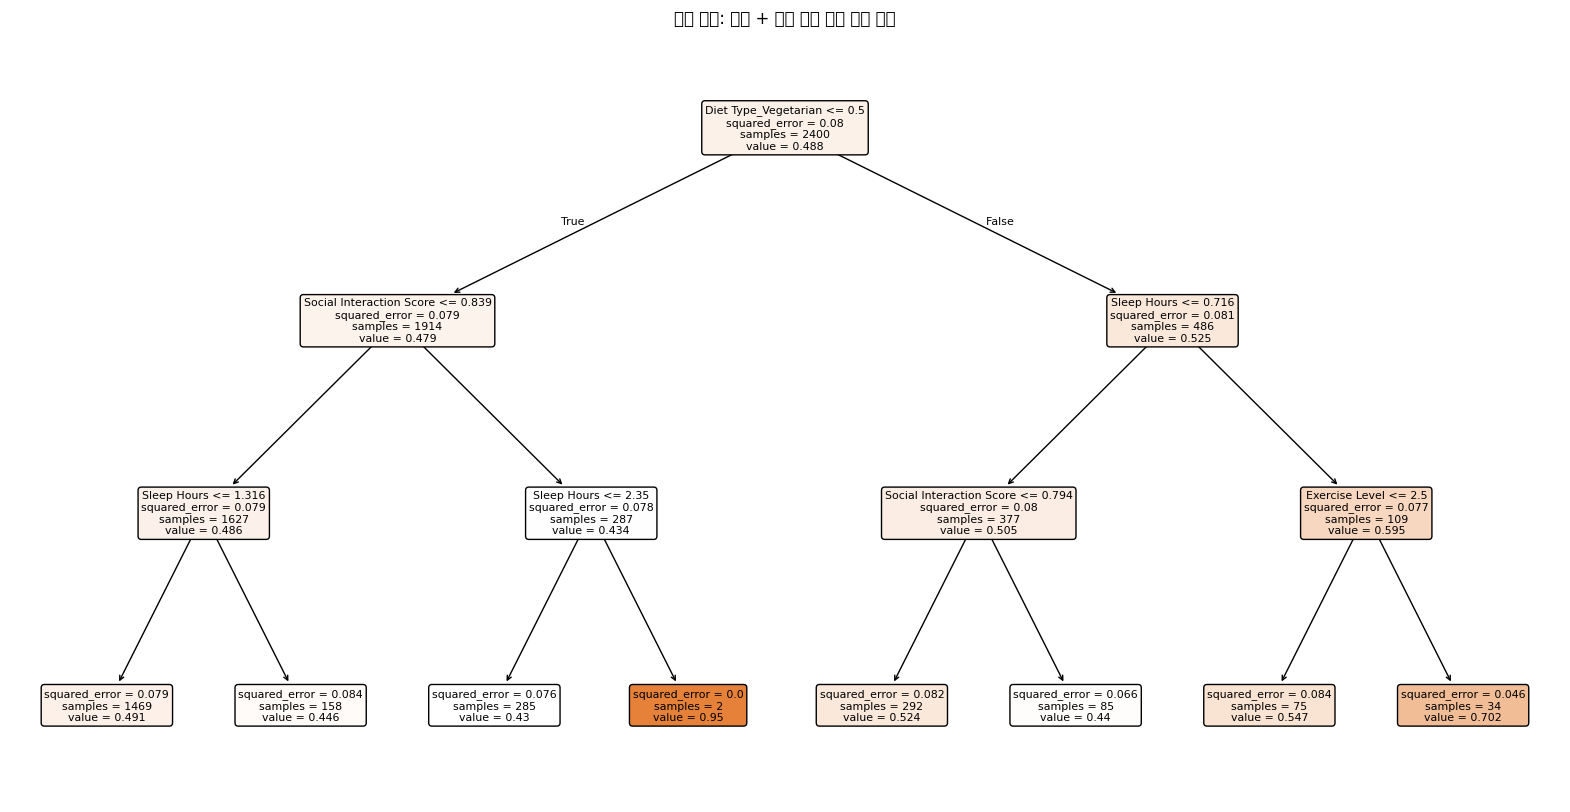

In [13]:
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns, filled=True, rounded=True)
plt.title("결정 트리: 루틴 + 식이 변수 기반 행복 예측")
plt.show()


텍스트 출력

In [14]:
tree_rules = export_text(model, feature_names=list(X.columns))
print(tree_rules)


|--- Diet Type_Vegetarian <= 0.50
|   |--- Social Interaction Score <= 0.84
|   |   |--- Sleep Hours <= 1.32
|   |   |   |--- value: [0.49]
|   |   |--- Sleep Hours >  1.32
|   |   |   |--- value: [0.45]
|   |--- Social Interaction Score >  0.84
|   |   |--- Sleep Hours <= 2.35
|   |   |   |--- value: [0.43]
|   |   |--- Sleep Hours >  2.35
|   |   |   |--- value: [0.95]
|--- Diet Type_Vegetarian >  0.50
|   |--- Sleep Hours <= 0.72
|   |   |--- Social Interaction Score <= 0.79
|   |   |   |--- value: [0.52]
|   |   |--- Social Interaction Score >  0.79
|   |   |   |--- value: [0.44]
|   |--- Sleep Hours >  0.72
|   |   |--- Exercise Level <= 2.50
|   |   |   |--- value: [0.55]
|   |   |--- Exercise Level >  2.50
|   |   |   |--- value: [0.70]



결정 트리 분기 조건 + 예측값(그 조건 만족하는 평균값)

In [15]:
def get_routine_rules(model, feature_names):
    tree = model.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree.feature
    ]
    rules = []

    def recurse(node, path):
        if tree.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree.threshold[node]
            # 왼쪽 (조건을 만족하는 경우)
            recurse(tree.children_left[node], path + [f"{name} <= {threshold:.2f}"])
            # 오른쪽 (조건을 만족하지 않는 경우)
            recurse(tree.children_right[node], path + [f"{name} > {threshold:.2f}"])
        else:
            value = tree.value[node][0][0]
            rules.append({
                "루틴 조건": " + ".join(path),
                "예측 행복 점수": round(value, 3)
            })

    recurse(0, [])
    return pd.DataFrame(rules).sort_values(by="예측 행복 점수", ascending=False)


In [16]:
rules_df = get_routine_rules(model, X.columns)
print(rules_df.head(10))

                                                                                   루틴 조건  \
3    Diet Type_Vegetarian <= 0.50 + Social Interaction Score > 0.84 + Sleep Hours > 2.35   
7               Diet Type_Vegetarian > 0.50 + Sleep Hours > 0.72 + Exercise Level > 2.50   
6              Diet Type_Vegetarian > 0.50 + Sleep Hours > 0.72 + Exercise Level <= 2.50   
4   Diet Type_Vegetarian > 0.50 + Sleep Hours <= 0.72 + Social Interaction Score <= 0.79   
0  Diet Type_Vegetarian <= 0.50 + Social Interaction Score <= 0.84 + Sleep Hours <= 1.32   
1   Diet Type_Vegetarian <= 0.50 + Social Interaction Score <= 0.84 + Sleep Hours > 1.32   
5    Diet Type_Vegetarian > 0.50 + Sleep Hours <= 0.72 + Social Interaction Score > 0.79   
2   Diet Type_Vegetarian <= 0.50 + Social Interaction Score > 0.84 + Sleep Hours <= 2.35   

   예측 행복 점수  
3     0.950  
7     0.702  
6     0.547  
4     0.524  
0     0.491  
1     0.446  
5     0.440  
2     0.430  


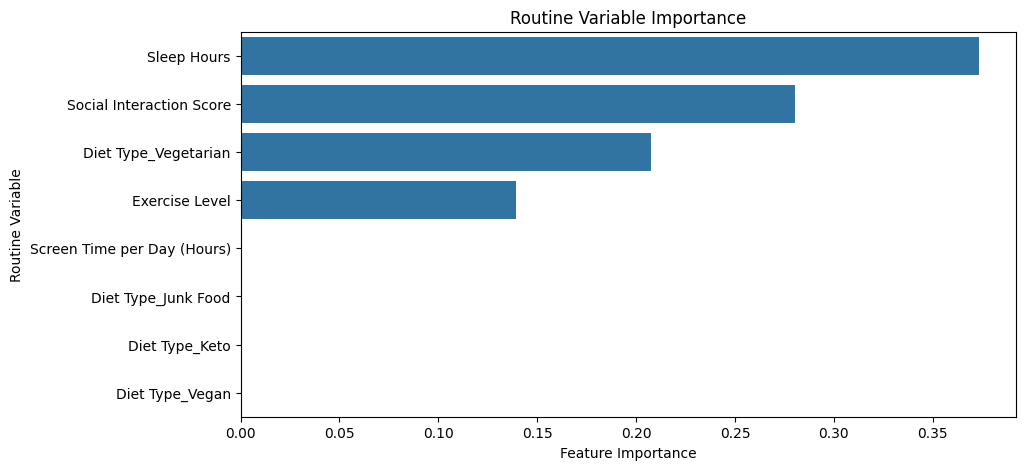

In [17]:
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Routine Variable Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Routine Variable")
plt.show()


In [ ]:
df['Predicted_Happiness'] = model.predict(X)
std_gap = df['Happiness Score'].std()
# 평균 기준으로 이상 집단 탐지
mean_happiness = df['Happiness Score'].mean()

# 가짜 건강 루틴: 예측은 높지만 실제는 낮음
fake_healthy = df[
    (df['Predicted_Happiness'] > df['Happiness Score']+ std_gap)
]

# 행복 과잉 예측자: 예측은 낮지만 실제는 높음
happiness_overachiever = df[
    (df['Predicted_Happiness']+ std_gap < df['Happiness Score'])
]

# 이상 집단 개수
print("평균 행복 점수:", round(mean_happiness, 3))
print("가짜 건강 루틴 수:", len(fake_healthy))
print("행복 과잉 예측자 수:", len(happiness_overachiever))

평균 행복 점수: 0.488
가짜 건강 루틴 수: 1117
행복 과잉 예측자 수: 289


##Random Forest 모델

In [27]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 기본 모델 (random_state 고정!)
rf = RandomForestRegressor(random_state=42)

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # 회귀 문제이므로 MSE 기반 평가
    cv=5,
    verbose=1,
    n_jobs=-1  # 모든 CPU 코어 사용
)

# 학습 수행
grid_search.fit(X_train, Y_train)

# 최적 모델 가져오기
best_rf_model = grid_search.best_estimator_

# 예측 및 평가
Y_pred_rf = best_rf_model.predict(X_test)
RF_MSE = mean_squared_error(Y_test, Y_pred_rf)
RF_R = r2_score(Y_test, Y_pred_rf)

print("Best Params:", grid_search.best_params_)
print(f"Tuned Random Forest MSE: {RF_MSE:.4f}")
print(f"Tuned Random Forest R²: {RF_R:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Params: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Random Forest MSE: 0.0828
Tuned Random Forest R²: 0.0089


In [30]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=3,
    random_state=42
)
rf_model.fit(X_train, Y_train)

# 예측 및 평가
Y_pred_rf = rf_model.predict(X_test)
RF_MSE=mean_squared_error(Y_test, Y_pred_rf)
RF_R=r2_score(Y_test, Y_pred_rf)
print(f"MSE: {RF_MSE:.4f}")
print(f"R² Score: {RF_R:.4f}")

MSE: 0.0828
R² Score: 0.0088


In [31]:
# TreeExplainer 사용
explainer = shap.Explainer(rf_model)
shap_values = explainer(X_test)

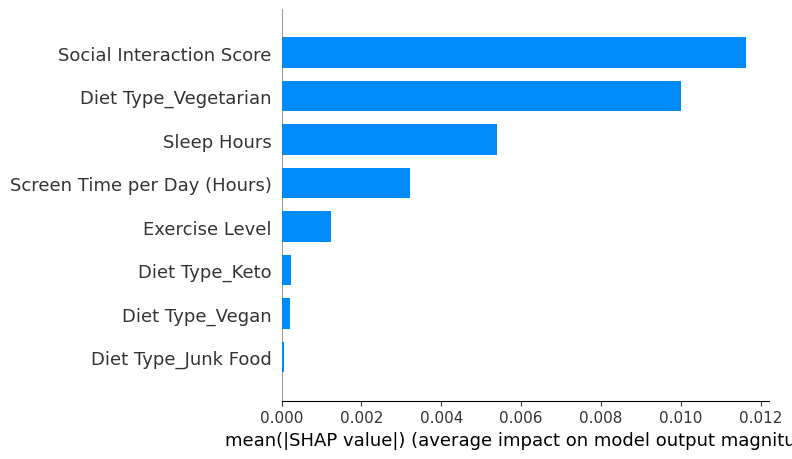

In [32]:
# SHAP 값 평균 기준 가장 중요한 변수 상위 N개 추출
shap.summary_plot(shap_values, X, plot_type="bar")


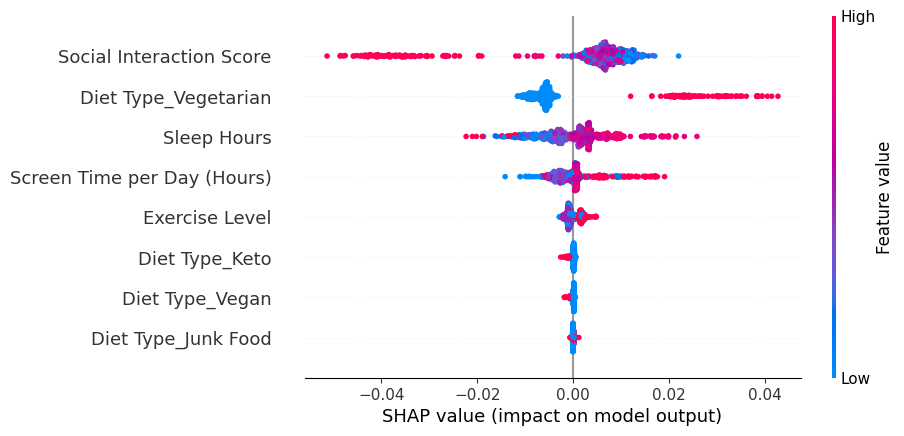

In [33]:
# SHAP 값 시각화
shap.plots.beeswarm(shap_values)

1. Social Interaction Score (사회적 상호작용)

빨간 점들이 오른쪽 끝에 많이 분포 →
사회적 상호작용 점수가 높을수록 행복도 예측이 증가함

행복 예측에 가장 긍정적인 기여

2. Diet Type_Vegetarian

SHAP 값이 양수 쪽에 몰림 →
채식주의자일수록 행복 예측에 긍정적인 영향

다이어트 타입 중에서는 이 변수가 가장 강한 영향

3. Sleep Hours

중간 SHAP 값 분포 →
수면 시간이 많다고 무조건 행복도 예측이 높아지진 않음

일부 고수면자에서는 오히려 마이너스 효과도 있음

(과도한 수면이 우울감과 관련된 현상”일 수 있음)

4. Screen Time per Day

파란 점이 왼쪽에 몰림 →
스크린 타임이 낮을수록 행복 예측이 높음

스크린 타임이 길수록 행복도 예측에 부정적 영향

In [34]:
tree = rf_model.estimators_[0]  # 랜덤포레스트 내 첫 번째 트리
tree_rules = export_text(tree, feature_names=list(X.columns))
print(tree_rules)

|--- Social Interaction Score <= 0.82
|   |--- Diet Type_Vegetarian <= 0.50
|   |   |--- Sleep Hours <= -1.55
|   |   |   |--- value: [0.41]
|   |   |--- Sleep Hours >  -1.55
|   |   |   |--- value: [0.50]
|   |--- Diet Type_Vegetarian >  0.50
|   |   |--- Sleep Hours <= 0.58
|   |   |   |--- value: [0.52]
|   |   |--- Sleep Hours >  0.58
|   |   |   |--- value: [0.63]
|--- Social Interaction Score >  0.82
|   |--- Screen Time per Day (Hours) <= 0.24
|   |   |--- Sleep Hours <= -1.15
|   |   |   |--- value: [0.24]
|   |   |--- Sleep Hours >  -1.15
|   |   |   |--- value: [0.54]
|   |--- Screen Time per Day (Hours) >  0.24
|   |   |--- Screen Time per Day (Hours) <= 0.31
|   |   |   |--- value: [0.28]
|   |   |--- Screen Time per Day (Hours) >  0.31
|   |   |   |--- value: [0.44]



In [35]:
RFrules_df = get_routine_rules(tree, X.columns)
print(RFrules_df.head(10))

                                                                                                        루틴 조건  \
3                         Social Interaction Score <= 0.82 + Diet Type_Vegetarian > 0.50 + Sleep Hours > 0.58   
5                 Social Interaction Score > 0.82 + Screen Time per Day (Hours) <= 0.24 + Sleep Hours > -1.15   
2                        Social Interaction Score <= 0.82 + Diet Type_Vegetarian > 0.50 + Sleep Hours <= 0.58   
1                       Social Interaction Score <= 0.82 + Diet Type_Vegetarian <= 0.50 + Sleep Hours > -1.55   
7   Social Interaction Score > 0.82 + Screen Time per Day (Hours) > 0.24 + Screen Time per Day (Hours) > 0.31   
0                      Social Interaction Score <= 0.82 + Diet Type_Vegetarian <= 0.50 + Sleep Hours <= -1.55   
6  Social Interaction Score > 0.82 + Screen Time per Day (Hours) > 0.24 + Screen Time per Day (Hours) <= 0.31   
4                Social Interaction Score > 0.82 + Screen Time per Day (Hours) <= 0.24 + Sleep H

In [36]:
df['Predicted_Happiness'] = rf_model.predict(X)

# 평균 기준으로 이상 집단 탐지
mean_happiness = df['Happiness Score'].mean()

# 가짜 건강 루틴: 예측은 높지만 실제는 낮음
rf_fake_healthy = df[
    (df['Predicted_Happiness'] > mean_happiness) &
    (df['Happiness Score'] < mean_happiness)
]

# 행복 과잉 예측자: 예측은 낮지만 실제는 높음
rf_happiness_overachiever = df[
    (df['Predicted_Happiness'] < mean_happiness) &
    (df['Happiness Score'] > mean_happiness)
]

# 이상 집단 개수
print("평균 행복 점수:", round(mean_happiness, 3))
print("가짜 건강 루틴 수:", len(fake_healthy))
print("행복 과잉 예측자 수:", len(happiness_overachiever))

평균 행복 점수: 0.488
가짜 건강 루틴 수: 1117
행복 과잉 예측자 수: 289


## XGBoost 모델

In [37]:
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 학습
xgb_model.fit(X_train, Y_train)

# 예측
Y_pred = xgb_model.predict(X_test)


MSE: 0.0890
R² Score: -0.0655


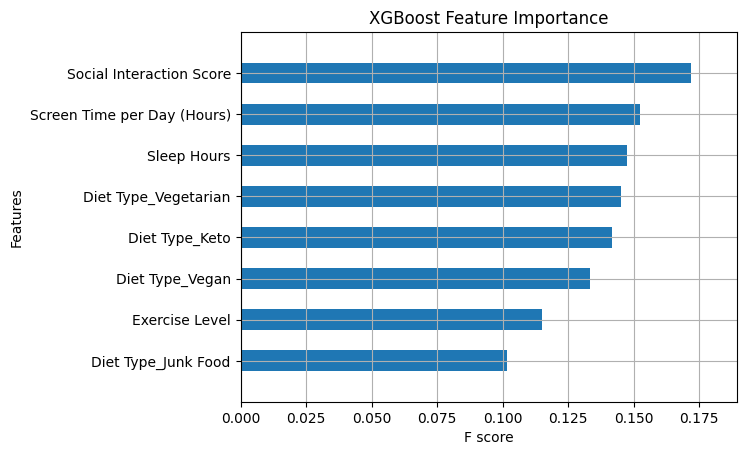

In [38]:
# 평가
XGBoost_MSE = mean_squared_error(Y_test, Y_pred)
XGBoost_R= r2_score(Y_test, Y_pred)
print(f"MSE: {XGBoost_MSE:.4f}")
print(f"R² Score: {XGBoost_R:.4f}")

xgb.plot_importance(xgb_model, height=0.5, importance_type='gain', show_values=False)
plt.title("XGBoost Feature Importance")
plt.show()

Shap 사용

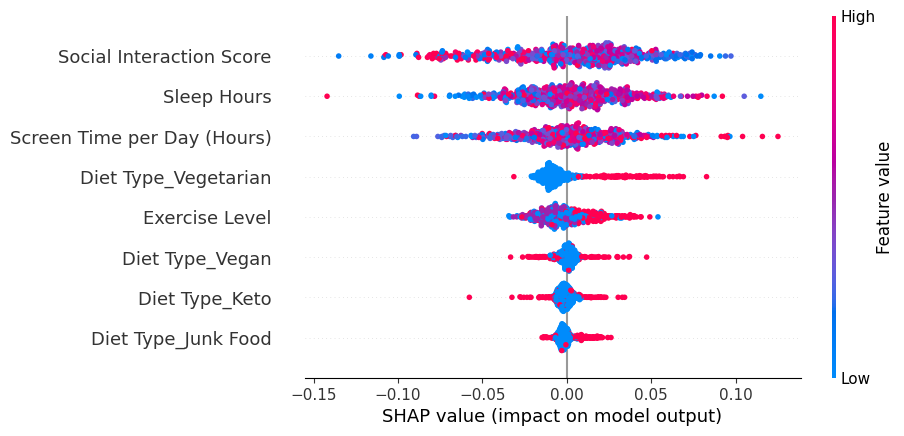

In [39]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)

##모델 별 MSE , $R^2$

In [40]:
results = pd.DataFrame({
    "모델": ["Decision Tree", "Random Forest", "XGBoost"],
    "MSE": [mse, RF_MSE, XGBoost_MSE],
    "R² Score": [r2, RF_R, XGBoost_R]
})

print(results)


              모델       MSE  R² Score
0  Decision Tree  0.083694 -0.001456
1  Random Forest  0.082836  0.008813
2        XGBoost  0.089045 -0.065491


전체적으로 음 막 설명력이 좋은 건 모르겠는데 그래도 rf가 그나마 나은 듯

##추가 XGbosst 튜닝해본거..

In [42]:
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 학습
xgb_model.fit(X_train, Y_train)

# 예측
Y_pred_xgb = xgb_model.predict(X_test)

# 평가
XGBoost_MSE = mean_squared_error(Y_test, Y_pred_xgb)
XGBoost_R = r2_score(Y_test, Y_pred_xgb)

print(f"Tuned XGBoost MSE: {XGBoost_MSE:.4f}")
print(f"Tuned XGBoost R²: {XGBoost_R:.4f}")

Tuned XGBoost MSE: 0.0879
Tuned XGBoost R²: -0.0515


GridSearchCV를 썼는데 이러면 RF보다 R-squared가 0.001커진 결과값이 나오긴 함.

In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_model = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_model.fit(X_train, Y_train)

best_model = grid_model.best_estimator_
print("Best XGBoost MSE:", mean_squared_error(Y_test, best_model.predict(X_test)))
print("Best XGBoost R²:", r2_score(Y_test, best_model.predict(X_test)))


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best XGBoost MSE: 0.08304389420406678
Best XGBoost R²: 0.006320994102753552


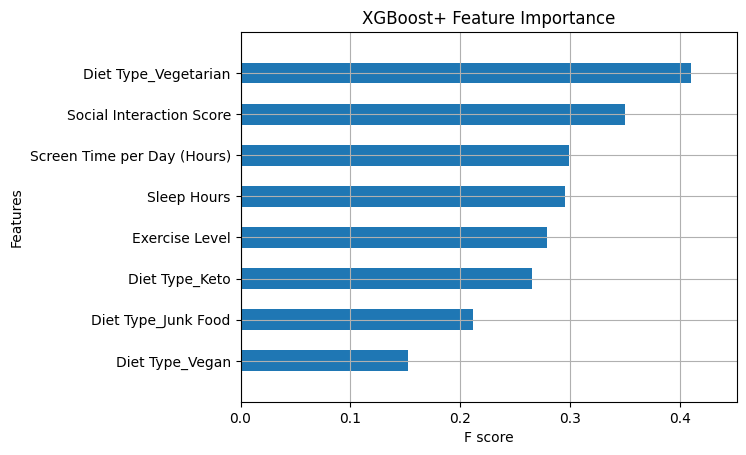

In [47]:
xgb.plot_importance(best_model, height=0.5, importance_type='gain', show_values=False)
plt.title("XGBoost+ Feature Importance")
plt.show()

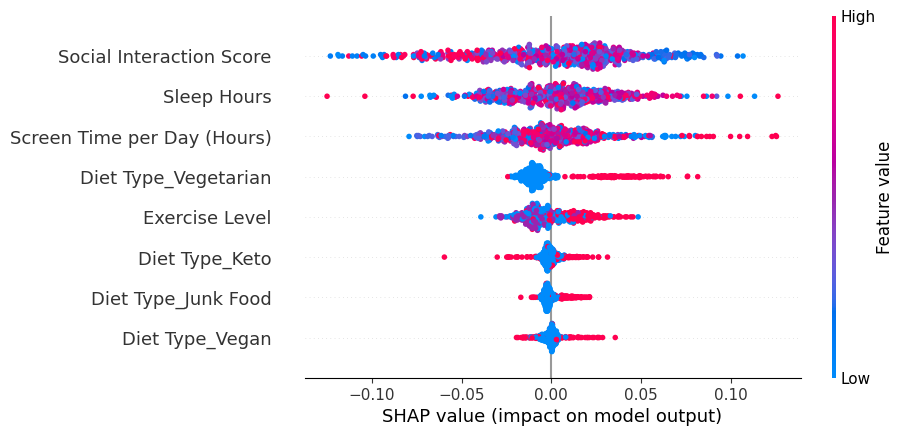

In [48]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)

##결정 트리가 뽑은 결과

In [ ]:
fake_healthy.to_csv("fake_healthy.csv", index=False)

In [46]:
rf_fake_healthy.to_csv("rf_fake_healthy.csv", index=False)

In [ ]:
happiness_overachiever.to_csv("happiness_overachiever.csv", index=False)

In [45]:
rf_happiness_overachiever.to_csv("rf_happiness_overachiever.csv", index=False)

In [ ]:
rules_df.to_csv("rules_df.csv", index=False)

In [44]:
RFrules_df.to_csv("RFrules_df.csv", index=False)

In [ ]:
df.to_csv("decisiontree_predict.csv", index=False)

#근로 시간 추가 트리

In [49]:
df_all=pd.read_csv("/content/processed_all_dataset2.csv")
df_all

,Age,Exercise Level,Sleep Hours,Stress Level,Work Hours per Week,Screen Time per Day (Hours),Social Interaction Score,Happiness Score,Country_Brazil,Country_Canada,...,Gender_Male,Gender_Other,Diet Type_Junk Food,Diet Type_Keto,Diet Type_Vegan,Diet Type_Vegetarian,Mental Health Condition_Bipolar,Mental Health Condition_Depression,Mental Health Condition_None,Mental Health Condition_PTSD
0,0.652174,1,-0.117319,1,0.025641,0.333333,0.755556,0.611111,1,0,...,1,0,0,0,0,1,0,0,1,0
1,0.282609,2,-1.050891,1,0.717949,0.533333,0.800000,0.644444,0,0,...,1,0,0,0,1,0,0,0,0,1
2,0.413043,1,0.482835,3,0.589744,0.450000,0.955556,0.966667,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0.369565,1,0.482835,1,0.589744,0.033333,0.800000,0.622222,1,0,...,1,0,0,0,1,0,0,1,0,0
4,0.608696,1,0.549519,1,0.384615,0.266667,0.411111,0.377778,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.847826,2,0.349467,3,0.230769,0.400000,0.966667,0.544444,0,0,...,0,0,0,0,0,0,0,1,0,0
2996,0.195652,1,0.416151,1,0.692308,0.900000,0.588889,0.988889,0,0,...,1,0,1,0,0,0,0,0,1,0
2997,0.521739,2,-0.317370,3,0.076923,0.316667,0.466667,0.344444,0,0,...,1,0,0,0,0,0,0,1,0,0
2998,0.152174,3,-0.517421,1,0.794872,0.383333,0.544444,0.344444,0,0,...,1,0,0,1,0,0,0,0,0,0


In [50]:
routine_vars_2 = [
    'Exercise Level',
    'Sleep Hours',
    'Screen Time per Day (Hours)',
    'Work Hours per Week',
    'Social Interaction Score',
    'Diet Type_Junk Food',
    'Diet Type_Keto',
    'Diet Type_Vegan',
    'Diet Type_Vegetarian'
]

X_2 = df_all[routine_vars_2]

In [51]:
X_2_train, X_2_test, Y_train, Y_test = train_test_split(
    X_2, Y, test_size=0.2, random_state=42
)

In [52]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1
)

grid_search.fit(X_2_train, Y_train)

best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5}
Best MSE: 0.08161193471261377


In [53]:
model = DecisionTreeRegressor(
    max_depth=3,              # 트리 깊이 제한
    min_samples_split=5,     # 노드 분할 최소 샘플 수
    random_state=42
)
model.fit(X_2_train, Y_train)

DecisionTreeRegressor(max_depth=3, min_samples_split=5, random_state=42)

In [54]:
Y_pred = model.predict(X_2_test)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 0.0842
R² Score: -0.0079


In [55]:
tree_rules = export_text(model, feature_names=list(X_2.columns))
print(tree_rules)

|--- Diet Type_Vegetarian <= 0.50
|   |--- Social Interaction Score <= 0.84
|   |   |--- Sleep Hours <= 1.32
|   |   |   |--- value: [0.49]
|   |   |--- Sleep Hours >  1.32
|   |   |   |--- value: [0.45]
|   |--- Social Interaction Score >  0.84
|   |   |--- Work Hours per Week <= 0.47
|   |   |   |--- value: [0.48]
|   |   |--- Work Hours per Week >  0.47
|   |   |   |--- value: [0.39]
|--- Diet Type_Vegetarian >  0.50
|   |--- Sleep Hours <= 0.72
|   |   |--- Social Interaction Score <= 0.79
|   |   |   |--- value: [0.52]
|   |   |--- Social Interaction Score >  0.79
|   |   |   |--- value: [0.44]
|   |--- Sleep Hours >  0.72
|   |   |--- Exercise Level <= 2.50
|   |   |   |--- value: [0.55]
|   |   |--- Exercise Level >  2.50
|   |   |   |--- value: [0.70]



In [56]:
rules_df_2 = get_routine_rules(model, X_2.columns)
print(rules_df_2.head(10))

                                                                                          루틴 조건  \
7                      Diet Type_Vegetarian > 0.50 + Sleep Hours > 0.72 + Exercise Level > 2.50   
6                     Diet Type_Vegetarian > 0.50 + Sleep Hours > 0.72 + Exercise Level <= 2.50   
4          Diet Type_Vegetarian > 0.50 + Sleep Hours <= 0.72 + Social Interaction Score <= 0.79   
0         Diet Type_Vegetarian <= 0.50 + Social Interaction Score <= 0.84 + Sleep Hours <= 1.32   
2  Diet Type_Vegetarian <= 0.50 + Social Interaction Score > 0.84 + Work Hours per Week <= 0.47   
1          Diet Type_Vegetarian <= 0.50 + Social Interaction Score <= 0.84 + Sleep Hours > 1.32   
5           Diet Type_Vegetarian > 0.50 + Sleep Hours <= 0.72 + Social Interaction Score > 0.79   
3   Diet Type_Vegetarian <= 0.50 + Social Interaction Score > 0.84 + Work Hours per Week > 0.47   

   예측 행복 점수  
7     0.702  
6     0.547  
4     0.524  
0     0.491  
2     0.484  
1     0.446  
5     0.44

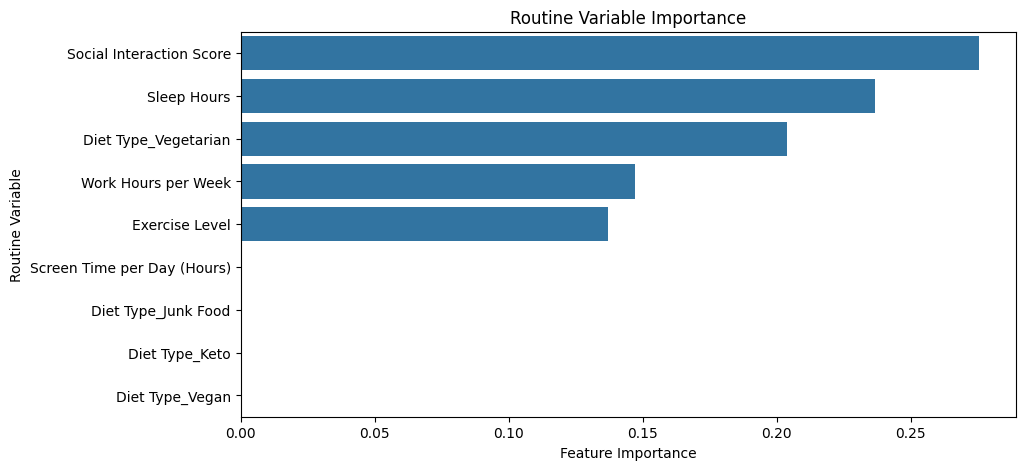

In [57]:
importances = pd.Series(model.feature_importances_, index=X_2.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Routine Variable Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Routine Variable")
plt.show()

In [58]:
df_all['Predicted_Happiness'] = model.predict(X_2)

# 평균 기준으로 이상 집단 탐지
mean_happiness_2 = df_all['Happiness Score'].mean()

# 가짜 건강 루틴: 예측은 높지만 실제는 낮음
fake_healthy_2 = df_all[
    (df_all['Predicted_Happiness'] > mean_happiness_2) &
    (df_all['Happiness Score'] < mean_happiness_2)
]

# 행복 과잉 예측자: 예측은 낮지만 실제는 높음
happiness_overachiever_2 = df_all[
    (df_all['Predicted_Happiness'] < mean_happiness_2) &
    (df_all['Happiness Score'] > mean_happiness_2)
]

# 이상 집단 개수
print("평균 행복 점수:", round(mean_happiness_2, 3))
print("가짜 건강 루틴 수:", len(fake_healthy_2))
print("행복 과잉 예측자 수:", len(happiness_overachiever_2))

평균 행복 점수: 0.488
가짜 건강 루틴 수: 1117
행복 과잉 예측자 수: 291


In [ ]:
fake_healthy_2.to_csv("fake_healthy_+work.csv", index=False)
happiness_overachiever_2.to_csv("happiness_overachiever_+work.csv", index=False)
rules_df_2.to_csv("rules_df_+work.csv", index=False)

##근로시간 추가한 거에 사회적 상호작용 제거한 버전

In [59]:
routine_vars_3 = [
    'Exercise Level',
    'Sleep Hours',
    'Screen Time per Day (Hours)',
    'Work Hours per Week',
    'Diet Type_Junk Food',
    'Diet Type_Keto',
    'Diet Type_Vegan',
    'Diet Type_Vegetarian'
]

X_3 = df_all[routine_vars_3]

In [60]:
X_3_train, X_3_test, Y_train, Y_test = train_test_split(
    X_3, Y, test_size=0.2, random_state=42
)

In [61]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1
)

grid_search.fit(X_3_train, Y_train)

best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best MSE: 0.08120860360908701


In [62]:
model = DecisionTreeRegressor(
    max_depth=3,              # 트리 깊이 제한
    min_samples_split=5,     # 노드 분할 최소 샘플 수
    random_state=42
)
model.fit(X_3_train, Y_train)

DecisionTreeRegressor(max_depth=3, min_samples_split=5, random_state=42)

In [63]:
Y_pred = model.predict(X_3_test)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 0.0841
R² Score: -0.0062


In [64]:
tree_rules = export_text(model, feature_names=list(X_3.columns))
print(tree_rules)

|--- Diet Type_Vegetarian <= 0.50
|   |--- Work Hours per Week <= 0.12
|   |   |--- Sleep Hours <= -1.58
|   |   |   |--- value: [0.31]
|   |   |--- Sleep Hours >  -1.58
|   |   |   |--- value: [0.52]
|   |--- Work Hours per Week >  0.12
|   |   |--- Work Hours per Week <= 0.14
|   |   |   |--- value: [0.38]
|   |   |--- Work Hours per Week >  0.14
|   |   |   |--- value: [0.48]
|--- Diet Type_Vegetarian >  0.50
|   |--- Sleep Hours <= 0.72
|   |   |--- Screen Time per Day (Hours) <= 0.16
|   |   |   |--- value: [0.43]
|   |   |--- Screen Time per Day (Hours) >  0.16
|   |   |   |--- value: [0.52]
|   |--- Sleep Hours >  0.72
|   |   |--- Exercise Level <= 2.50
|   |   |   |--- value: [0.55]
|   |   |--- Exercise Level >  2.50
|   |   |   |--- value: [0.70]



In [65]:
rules_df_3 = get_routine_rules(model, X_3.columns)
print(rules_df_3.head(10))

                                                                                     루틴 조건  \
7                 Diet Type_Vegetarian > 0.50 + Sleep Hours > 0.72 + Exercise Level > 2.50   
6                Diet Type_Vegetarian > 0.50 + Sleep Hours > 0.72 + Exercise Level <= 2.50   
1         Diet Type_Vegetarian <= 0.50 + Work Hours per Week <= 0.12 + Sleep Hours > -1.58   
5   Diet Type_Vegetarian > 0.50 + Sleep Hours <= 0.72 + Screen Time per Day (Hours) > 0.16   
3   Diet Type_Vegetarian <= 0.50 + Work Hours per Week > 0.12 + Work Hours per Week > 0.14   
4  Diet Type_Vegetarian > 0.50 + Sleep Hours <= 0.72 + Screen Time per Day (Hours) <= 0.16   
2  Diet Type_Vegetarian <= 0.50 + Work Hours per Week > 0.12 + Work Hours per Week <= 0.14   
0        Diet Type_Vegetarian <= 0.50 + Work Hours per Week <= 0.12 + Sleep Hours <= -1.58   

   예측 행복 점수  
7     0.702  
6     0.547  
1     0.521  
5     0.518  
3     0.476  
4     0.434  
2     0.380  
0     0.309  


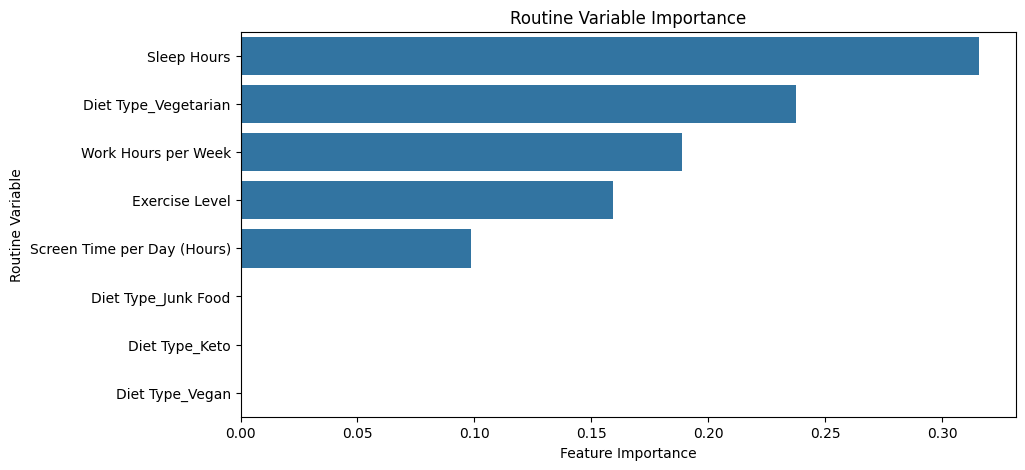

In [66]:
importances = pd.Series(model.feature_importances_, index=X_3.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Routine Variable Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Routine Variable")
plt.show()

In [67]:
df_all['Predicted_Happiness'] = model.predict(X_3)

# 평균 기준으로 이상 집단 탐지
mean_happiness_3 = df_all['Happiness Score'].mean()

# 가짜 건강 루틴: 예측은 높지만 실제는 낮음
fake_healthy_3 = df_all[
    (df_all['Predicted_Happiness'] > mean_happiness_3) &
    (df_all['Happiness Score'] < mean_happiness_3)
]

# 행복 과잉 예측자: 예측은 낮지만 실제는 높음
happiness_overachiever_3 = df_all[
    (df_all['Predicted_Happiness'] < mean_happiness_3) &
    (df_all['Happiness Score'] > mean_happiness_3)
]

# 이상 집단 개수
print("평균 행복 점수:", round(mean_happiness_3, 3))
print("가짜 건강 루틴 수:", len(fake_healthy_3))
print("행복 과잉 예측자 수:", len(happiness_overachiever_3))

평균 행복 점수: 0.488
가짜 건강 루틴 수: 342
행복 과잉 예측자 수: 1069


In [ ]:
fake_healthy_3.to_csv("fake_healthy_+work-social.csv", index=False)
happiness_overachiever_3.to_csv("happiness_overachiever_+work-social.csv", index=False)
rules_df_3.to_csv("rules_df_+work-social.csv", index=False)